In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime

from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from collections import Counter

In [2]:
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, GaussianNoise, Conv1D, MaxPool1D, GlobalMaxPooling1D
from keras.layers import Input, concatenate, SpatialDropout1D, Flatten, AvgPool1D, LSTM, Lambda, Reshape, GaussianDropout
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD, Nadam
import keras.backend as K
from keras.regularizers import l1, l2 , l1_l2


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data loading

In [3]:
tick_bars = pd.read_csv('tick_bars.csv')

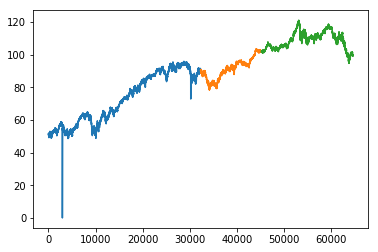

In [4]:
plt.figure()
plt.plot(tick_bars.close[:int(len(tick_bars) * 0.5)])
plt.plot(tick_bars.close[int(len(tick_bars) * 0.5):int(len(tick_bars) * 0.7)])
plt.plot(tick_bars.close[int(len(tick_bars) * 0.7):])
plt.show()

# Differentiation test

In [5]:
from statsmodels.tsa.stattools import adfuller

/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
# https://github.com/philipperemy/fractional-differentiation-time-series/blob/master/fracdiff/fracdiff.py

def fast_fracdiff(x, d):
    import pylab as pl
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

In [7]:
corrs, adfs = [], []

for d in np.arange(0.0, 1.5, 0.5):
    
    print d
    
    ts1 = np.log(tick_bars.close.values)
    ts2 = fast_fracdiff(ts1, d)

    corr = np.corrcoef(ts1, ts2)[0,1]
    adf = adfuller(ts2)[0]

    corrs.append(corr)
    adfs.append(adf)

0.0
0.5
1.0


In [8]:
stats = pd.DataFrame({
    'd': np.arange(0.0, 1.5, 0.5),
    'corr': np.abs(corrs),
    'adfs': adfs
})
stats.index = stats['d']

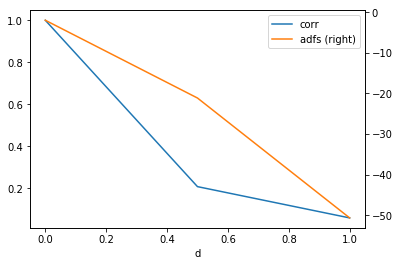

In [9]:
stats[['corr', 'adfs']].plot(secondary_y='adfs')
plt.show()

# Making features

In [10]:
from scipy.stats import entropy
from scipy import stats

In [11]:
N_BARS = 64000
WINDOW_LONG = 100
WINDOW_SHORT = 50
HORIZON = 25
T = 0.01
H = 0.05

In [12]:
print pd.Series.autocorr(np.clip(tick_bars.close.pct_change(), -H, H).dropna())
print stats.jarque_bera(np.clip(tick_bars.close.pct_change(), -H, H).dropna())
print stats.shapiro(np.clip(tick_bars.close.pct_change(), -H, H).dropna())

-0.04359708998044693
(30474097.664683025, 0.0)
(0.727247953414917, 0.0)


/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [13]:
tick_bars['pct_change'] = np.clip(tick_bars.close.pct_change(), -H, H)
tick_bars['pct_change_frac'] = np.clip(fast_fracdiff(np.log(tick_bars.close.values), d=0.5), 0, 0.1)

In [14]:
FEATURES = ['pct_change_frac']
print FEATURES

['pct_change_frac']


In [15]:
def make_features_from_window(X_train_b, X_val, X_test, features):   
    
    X_train_normts = np.array([(x.close - x.close.iloc[0]) / np.std(x.close) for x in X_train_b]).reshape((len(X_train_b), WINDOW_LONG, 1))
    X_val_normts = np.array([(x.close - x.close.iloc[0]) / np.std(x.close) for x in X_val]).reshape((len(X_val), WINDOW_LONG, 1))
    X_test_normts = np.array([(x.close - x.close.iloc[0]) / np.std(x.close) for x in X_test]).reshape((len(X_test), WINDOW_LONG, 1))
    
    X_train_normv = np.array([(x.volume - x.volume.iloc[0]) / np.std(x.volume) for x in X_train_b]).reshape((len(X_train_b), WINDOW_LONG, 1))
    X_val_normvv = np.array([(x.volume - x.volume.iloc[0]) / np.std(x.volume) for x in X_val]).reshape((len(X_val), WINDOW_LONG, 1))
    X_test_normv = np.array([(x.volume - x.volume.iloc[0]) / np.std(x.volume) for x in X_test]).reshape((len(X_test), WINDOW_LONG, 1))
  
    X_train = np.array([x[features].fillna(0.).values.tolist() for x in X_train_b]) 
    X_val = np.array([x[features].fillna(0.).values.tolist() for x in X_val])
    X_test = np.array([x[features].fillna(0.).values.tolist() for x in X_test])

    X_train = np.concatenate((X_train, X_train_normts, X_train_normv), axis = -1)
    X_val = np.concatenate((X_val, X_val_normts, X_val_normvv), axis = -1)
    X_test = np.concatenate((X_test, X_test_normts, X_test_normv), axis = -1)
    
    return X_train, X_val, X_test

In [16]:
def get_class_weights(y):
    y = [np.argmax(x) for x in y]
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

# Fixed horizon

In [17]:
X, labels = [], []
for i in range(WINDOW_LONG, N_BARS, 1):
    
    window = tick_bars.iloc[i-WINDOW_LONG:i]
#     window = tick_bars.iloc[i]
    now = tick_bars.close[i]
    future = tick_bars.close[i+HORIZON]
    ret = (future - now) / now
    
    X.append(window)
    if ret > T:
        labels.append(1)
    elif ret < -T:
        labels.append(-1)
    else:
        labels.append(0)

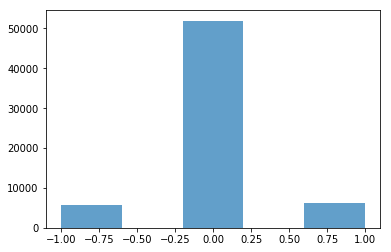

In [18]:
plt.figure()
plt.hist(labels, bins = 5, alpha = 0.7)
plt.show()

In [19]:
X_train, X_val, X_test = X[:int(len(X) * 0.5)], X[int(len(X) * 0.6):int(len(X) * 0.7)], X[int(len(X) * 0.8):]
Y_train, Y_val, Y_test = labels[:int(len(X) * 0.5)], labels[int(len(X) * 0.6):int(len(X) * 0.7)], labels[int(len(X) * 0.8):]

lbr = LabelBinarizer()
Y_train = lbr.fit_transform(Y_train)
Y_val = lbr.transform(Y_val)
Y_test = lbr.transform(Y_test)

X_train, X_val, X_test = make_features_from_window(X_train, X_val, X_test, FEATURES)

In [20]:
def cnn(shape):
    main_input = Input(shape=shape, name='main_input')
    x = Flatten()(main_input)
    x = Dropout(0.25)(x)
    output = Dense(3, activation = "softmax")(x)
    
    final_model = Model(inputs=[main_input], outputs=[output])
    return final_model

model = cnn((WINDOW_LONG, len(X_train[0][0]), ))
model.summary()

model.compile(optimizer=Adam(lr = 0.01),  
                        loss=['categorical_crossentropy'], 
                        metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, Y_train, 
              epochs = 100, 
              batch_size = 16, 
              verbose=True, 
              validation_data = (X_val, Y_val),
              callbacks=[checkpointer, es],
              shuffle=True, 
              class_weight = get_class_weights(np.concatenate((Y_train, Y_val)))
                )

model.load_weights("test.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100, 3)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total params: 903
Trainable params: 903
Non-trainable params: 0
_________________________________________________________________
Train on 31950 samples, validate on 6390 samples
Epoch 1/100
31950/31950 [==============================] - 5s 158us/step - loss: 4.2498 - acc: 0.3177 - val_loss: 1.3153 - val_acc: 0.2951
Epoch 2/100
31950/31950 [==============================] - 5s 166us/step - loss: 4.1291 

              precision    recall  f1-score   support

           0       0.02      0.30      0.04       211
           1       0.92      0.30      0.45      5934
           2       0.04      0.26      0.06       245

   micro avg       0.30      0.30      0.30      6390
   macro avg       0.33      0.28      0.19      6390
weighted avg       0.86      0.30      0.42      6390

[[  63   68   80]
 [2606 1760 1568]
 [ 101   81   63]]


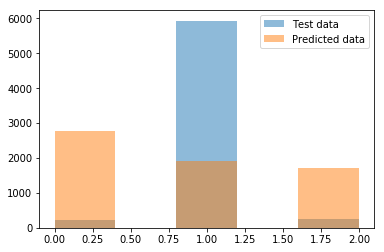

              precision    recall  f1-score   support

           0       0.07      0.38      0.11       899
           1       0.89      0.29      0.44     11116
           2       0.07      0.36      0.12       765

   micro avg       0.30      0.30      0.30     12780
   macro avg       0.34      0.34      0.22     12780
weighted avg       0.78      0.30      0.40     12780

[[ 346  189  364]
 [4612 3222 3282]
 [ 286  207  272]]


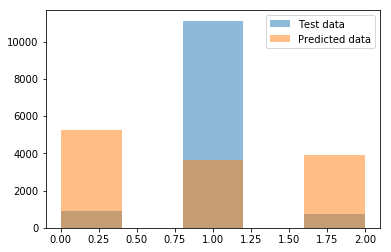

In [21]:
pred = model.predict(X_val)

print classification_report([np.argmax(y) for y in Y_val],
                            [np.argmax(y) for y in pred])

print confusion_matrix([np.argmax(y) for y in Y_val],
                            [np.argmax(y) for y in pred])

plt.plot()
plt.hist([np.argmax(y) for y in Y_val], bins = 5, alpha = 0.5, label = 'Test data')
plt.hist([np.argmax(y) for y in pred], bins = 5, alpha = 0.5, label = 'Predicted data')
plt.legend()
plt.show()


pred = model.predict(X_test)

print classification_report([np.argmax(y) for y in Y_test],
                            [np.argmax(y) for y in pred])

print confusion_matrix([np.argmax(y) for y in Y_test],
                            [np.argmax(y) for y in pred])

plt.plot()
plt.hist([np.argmax(y) for y in Y_test], bins = 5, alpha = 0.5, label = 'Test data')
plt.hist([np.argmax(y) for y in pred], bins = 5, alpha = 0.5, label = 'Predicted data')
plt.legend()
plt.show()

In [22]:
pred

array([[0.22662833, 0.42735487, 0.3460168 ],
       [0.02252634, 0.31241223, 0.6650614 ],
       [0.31027994, 0.28352553, 0.40619454],
       ...,
       [0.3319831 , 0.39908785, 0.26892897],
       [0.4245464 , 0.23618537, 0.3392682 ],
       [0.5815889 , 0.18120623, 0.2372049 ]], dtype=float32)

# Volatility horizon

In [23]:
X, labels = [], []
for i in range(WINDOW_LONG, N_BARS, 1):
    window = tick_bars.iloc[i-WINDOW_LONG:i]
    now = tick_bars.close[i]
    future = tick_bars.close[i+HORIZON]
    ret = (future - now) / now
    
    window_abs_returns = np.abs(window.close.pct_change())
    Ti = np.std(window_abs_returns) + np.mean(window_abs_returns)
    
    X.append(window)
    if ret > Ti:
        labels.append(1)
    elif ret < -Ti:
        labels.append(-1)
    else:
        labels.append(0)

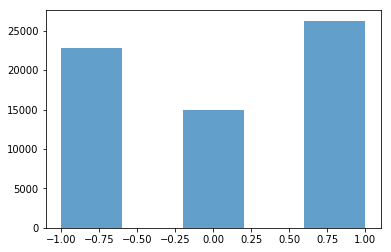

In [24]:
plt.figure()
plt.hist(labels, bins = 5, alpha = 0.7)
plt.show()

In [25]:
X_train, X_val, X_test = X[:int(len(X) * 0.5)], X[int(len(X) * 0.6):int(len(X) * 0.7)], X[int(len(X) * 0.8):]
Y_train, Y_val, Y_test = labels[:int(len(X) * 0.5)], labels[int(len(X) * 0.6):int(len(X) * 0.7)], labels[int(len(X) * 0.8):]

lbr = LabelBinarizer()
Y_train = lbr.fit_transform(Y_train)
Y_val = lbr.transform(Y_val)
Y_test = lbr.transform(Y_test)

X_train, X_val, X_test = make_features_from_window(X_train, X_val, X_test, FEATURES)

In [26]:
def cnn(shape):
    main_input = Input(shape=shape, name='main_input')
    x = Flatten()(main_input)
    x = Dropout(0.25)(x)
    output = Dense(3, activation = "softmax")(x)
    
    final_model = Model(inputs=[main_input], outputs=[output])
    return final_model

model = cnn((WINDOW_LONG, len(X_train[0][0]), ))
model.summary()

model.compile(optimizer=Adam(lr = 0.01),  
                        loss=['categorical_crossentropy'], 
                        metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, Y_train, 
              epochs = 100, 
              batch_size = 16, 
              verbose=True, 
              validation_data = (X_val, Y_val),
              callbacks=[checkpointer, es],
              shuffle=True, 
              class_weight = get_class_weights(np.concatenate((Y_train, Y_val)))
                )

model.load_weights("test.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100, 3)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total params: 903
Trainable params: 903
Non-trainable params: 0
_________________________________________________________________
Train on 31950 samples, validate on 6390 samples
Epoch 1/100
31950/31950 [==============================] - 11s 342us/step - loss: 1.9417 - acc: 0.3350 - val_loss: 1.3366 - val_acc: 0.3812
Epoch 2/100
31950/31950 [==============================] - 6s 188us/step - loss: 1.9176

              precision    recall  f1-score   support

           0       0.31      0.34      0.33      2095
           1       0.23      0.33      0.27      1518
           2       0.41      0.29      0.34      2777

   micro avg       0.32      0.32      0.32      6390
   macro avg       0.32      0.32      0.31      6390
weighted avg       0.34      0.32      0.32      6390

[[ 714  708  673]
 [ 536  496  486]
 [1045  914  818]]


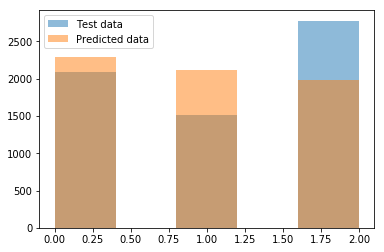

              precision    recall  f1-score   support

           0       0.41      0.40      0.41      4922
           1       0.23      0.32      0.27      2896
           2       0.42      0.33      0.37      4962

   micro avg       0.36      0.36      0.36     12780
   macro avg       0.35      0.35      0.35     12780
weighted avg       0.37      0.36      0.36     12780

[[1965 1577 1380]
 [1045  940  911]
 [1757 1565 1640]]


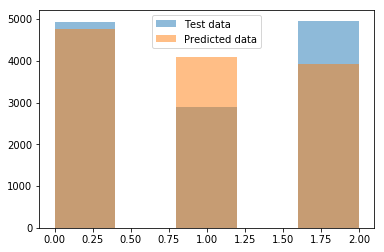

In [27]:
pred = model.predict(X_val)

print classification_report([np.argmax(y) for y in Y_val],
                            [np.argmax(y) for y in pred])

print confusion_matrix([np.argmax(y) for y in Y_val],
                            [np.argmax(y) for y in pred])

plt.plot()
plt.hist([np.argmax(y) for y in Y_val], bins = 5, alpha = 0.5, label = 'Test data')
plt.hist([np.argmax(y) for y in pred], bins = 5, alpha = 0.5, label = 'Predicted data')
plt.legend()
plt.show()


pred = model.predict(X_test)

print classification_report([np.argmax(y) for y in Y_test],
                            [np.argmax(y) for y in pred])

print confusion_matrix([np.argmax(y) for y in Y_test],
                            [np.argmax(y) for y in pred])

plt.plot()
plt.hist([np.argmax(y) for y in Y_test], bins = 5, alpha = 0.5, label = 'Test data')
plt.hist([np.argmax(y) for y in pred], bins = 5, alpha = 0.5, label = 'Predicted data')
plt.legend()
plt.show()

In [28]:
print get_class_weights(np.concatenate((Y_train, Y_val)))
print lbr.classes_

{0: 1.23, 1: 1.82, 2: 1.0}
[-1  0  1]


# Meta labeling

In [29]:
def get_meta_barier(future_window, last_close, min_ret, tp, sl, vertical_zero = False):
    '''
        XXX
    '''
    if vertical_zero:
        min_ret_situation = [0, 0, 0]
    else:
        min_ret_situation = [0, 0]
        
        
    differences = np.array([(fc - last_close) / last_close for fc in future_window])
    
    # Are there gonna be fluctuations within min_ret???
    min_ret_ups = np.where((differences >= min_ret) == True)[0]
    min_ret_downs = np.where((differences < -min_ret) == True)[0]
  
    if (len(min_ret_ups) == 0) and (len(min_ret_downs) == 0):
        if vertical_zero:
            min_ret_situation[2] = 1
        else:
            if differences[-1] > 0:
                min_ret_situation[0] = 1
            else:
                min_ret_situation[1] = 1            
    else:
        if len(min_ret_ups) == 0: min_ret_ups = [np.inf]
        if len(min_ret_downs) == 0: min_ret_downs = [np.inf]
        if min_ret_ups[0] > min_ret_downs[0]:
            min_ret_situation[0] = 1
        else:
            min_ret_situation[1] = 1
        
    #  Take profit and stop losses indices
    take_profit = np.where((differences >= tp) == True)[0]
    stop_loss = np.where((differences < sl) == True)[0]
    
    # Fluctuation directions coincide with take profit / stop loss actions?
    if min_ret_situation[0] == 1 and len(take_profit) != 0:
        take_action = 1
    elif min_ret_situation[1] == 1 and len(stop_loss) != 0:
        take_action = 1
    else:
        take_action = 0.
    
    return min_ret_situation, take_action

In [30]:
TP = T
SL = -T

X, Y, Y2 = [], [], []
for i in range(WINDOW_LONG, N_BARS, 1):
    window = tick_bars.iloc[i-WINDOW_LONG:i]
    now = tick_bars.close[i]
    future_window = tick_bars.close[i:i+HORIZON]
    
    window_abs_returns = np.abs(window.close.pct_change())
    Ti = np.std(window_abs_returns) + np.mean(window_abs_returns)
    
    min_ret_situation, take_action = get_meta_barier(future_window, now, Ti, TP, SL, True)
    X.append(window)
    Y.append(min_ret_situation)
    Y2.append(take_action)

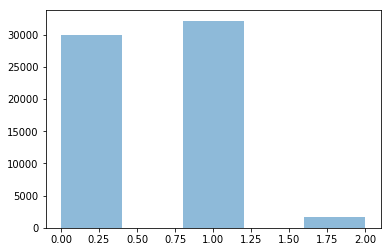

In [31]:
plt.figure()
plt.hist([np.argmax(x) for x in Y], alpha = 0.5, bins = 5)
plt.show()

In [32]:
X_train, X_val, X_test = X[:int(len(X) * 0.5)], X[int(len(X) * 0.6):int(len(X) * 0.7)], X[int(len(X) * 0.8):]
Y_train, Y_val, Y_test = Y[:int(len(X) * 0.5)], Y[int(len(X) * 0.6):int(len(X) * 0.7)], Y[int(len(X) * 0.8):]

X_train, X_val, X_test = make_features_from_window(X_train, X_val, X_test, FEATURES)

In [33]:
Y_train, Y_val, Y_test = np.array(Y_train), np.array(Y_val), np.array(Y_test)

In [34]:
def cnn(shape):
    main_input = Input(shape=shape, name='main_input')
    x = Flatten()(main_input)
    x = Dropout(0.25)(x)
    output = Dense(3, activation = "softmax")(x)
    
    final_model = Model(inputs=[main_input], outputs=[output])
    return final_model

model = cnn((WINDOW_LONG, len(X_train[0][0]), ))
model.summary()

model.compile(optimizer=Adam(lr = 0.01),  
                        loss=['categorical_crossentropy'], 
                        metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, Y_train, 
              epochs = 100, 
              batch_size = 16, 
              verbose=True, 
              validation_data = (X_val, Y_val),
              callbacks=[checkpointer, es],
              shuffle=True, 
              class_weight = get_class_weights(np.concatenate((Y_train, Y_val)))
                )

model.load_weights("test.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100, 3)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 300)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 903       
Total params: 903
Trainable params: 903
Non-trainable params: 0
_________________________________________________________________
Train on 31950 samples, validate on 6390 samples
Epoch 1/100
31950/31950 [==============================] - 6s 202us/step - loss: 3.2768 - acc: 0.3455 - val_loss: 1.6196 - val_acc: 0.3700
Epoch 2/100
31950/31950 [==============================] - 6s 200us/step - loss: 3.3883 

              precision    recall  f1-score   support

           0       0.45      0.47      0.46      2865
           1       0.51      0.33      0.40      3307
           2       0.05      0.28      0.08       218

   micro avg       0.39      0.39      0.39      6390
   macro avg       0.33      0.36      0.31      6390
weighted avg       0.47      0.39      0.41      6390

[[1335  961  569]
 [1568 1081  658]
 [  72   85   61]]


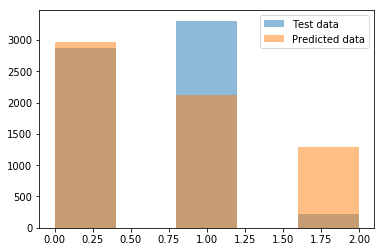

              precision    recall  f1-score   support

           0       0.49      0.46      0.48      6225
           1       0.49      0.36      0.41      6189
           2       0.03      0.19      0.05       366

   micro avg       0.41      0.41      0.41     12780
   macro avg       0.34      0.34      0.31     12780
weighted avg       0.48      0.41      0.43     12780

[[2889 2232 1104]
 [2767 2220 1202]
 [ 184  113   69]]


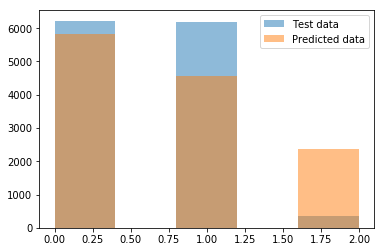

In [35]:
pred = model.predict(X_val)

print classification_report([np.argmax(y) for y in Y_val],
                            [np.argmax(y) for y in pred])

print confusion_matrix([np.argmax(y) for y in Y_val],
                            [np.argmax(y) for y in pred])

plt.plot()
plt.hist([np.argmax(y) for y in Y_val], bins = 5, alpha = 0.5, label = 'Test data')
plt.hist([np.argmax(y) for y in pred], bins = 5, alpha = 0.5, label = 'Predicted data')
plt.legend()
plt.show()


pred = model.predict(X_test)

print classification_report([np.argmax(y) for y in Y_test],
                            [np.argmax(y) for y in pred])

print confusion_matrix([np.argmax(y) for y in Y_test],
                            [np.argmax(y) for y in pred])

plt.plot()
plt.hist([np.argmax(y) for y in Y_test], bins = 5, alpha = 0.5, label = 'Test data')
plt.hist([np.argmax(y) for y in pred], bins = 5, alpha = 0.5, label = 'Predicted data')
plt.legend()
plt.show()

In [36]:
X_train, X_val, X_test = X[:int(len(X) * 0.5)], X[int(len(X) * 0.6):int(len(X) * 0.7)], X[int(len(X) * 0.8):]
Y_train, Y_val, Y_test = Y2[:int(len(X) * 0.5)], Y2[int(len(X) * 0.6):int(len(X) * 0.7)], Y2[int(len(X) * 0.8):]

X_train, X_val, X_test = make_features_from_window(X_train, X_val, X_test, FEATURES)
P_train, P_val, P_test = model.predict(X_train), model.predict(X_val), model.predict(X_test)

In [37]:
Y_train = np.array([[1, 0] if x == 1 else [0, 1] for x in Y_train])
Y_val = np.array([[1, 0] if x == 1 else [0, 1] for x in Y_val])
Y_test = np.array([[1, 0] if x == 1 else [0, 1] for x in Y_test])

In [38]:
def cnn(shape):
    main_input = Input(shape=shape, name='main_input')
    aux_input = Input((3, ), name='meta')
    
    x = Flatten()(main_input)
    x = Dropout(0.25)(x)
    x = concatenate([x, aux_input])
    output = Dense(2, activation = "softmax")(x)
    
    final_model = Model(inputs=[main_input, aux_input], outputs=[output])
    return final_model


model = cnn((WINDOW_LONG, len(X_train[0][0]), ))
model.summary()

model.compile(optimizer=Adam(lr = 0.01),  
                        loss=['categorical_crossentropy'], 
                        metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit([X_train, P_train], Y_train, 
              epochs = 100, 
              batch_size = 16, 
              verbose=True, 
              validation_data = ([X_test, P_test], Y_test),
              callbacks=[checkpointer, es],
              shuffle=True, 
              class_weight = get_class_weights(np.concatenate((Y_train, Y_val))))

model.load_weights("test.hdf5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 300)          0           main_input[0][0]                 
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 300)          0           flatten_4[0][0]                  
__________________________________________________________________________________________________
meta (InputLayer)               (None, 3)            0                                            
__________________________________________________________________________________________________
concatenat

              precision    recall  f1-score   support

           0       0.02      0.43      0.04       120
           1       0.98      0.62      0.76      6270

   micro avg       0.62      0.62      0.62      6390
   macro avg       0.50      0.53      0.40      6390
weighted avg       0.96      0.62      0.75      6390

[[  52   68]
 [2361 3909]]


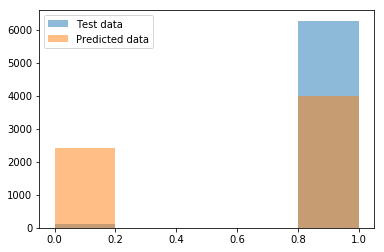

              precision    recall  f1-score   support

           0       0.03      0.43      0.06       360
           1       0.97      0.63      0.76     12420

   micro avg       0.62      0.62      0.62     12780
   macro avg       0.50      0.53      0.41     12780
weighted avg       0.95      0.62      0.74     12780

[[ 154  206]
 [4648 7772]]


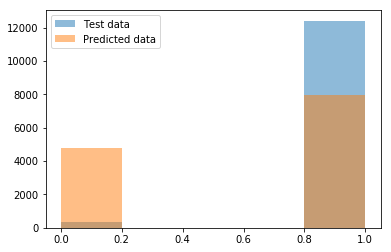

In [39]:
pred = model.predict([X_val, P_val])

print classification_report([np.argmax(y) for y in Y_val],
                            [np.argmax(y) for y in pred])

print confusion_matrix([np.argmax(y) for y in Y_val],
                            [np.argmax(y) for y in pred])

plt.plot()
plt.hist([np.argmax(y) for y in Y_val], bins = 5, alpha = 0.5, label = 'Test data')
plt.hist([np.argmax(y) for y in pred], bins = 5, alpha = 0.5, label = 'Predicted data')
plt.legend()
plt.show()


pred = model.predict([X_test, P_test])

print classification_report([np.argmax(y) for y in Y_test],
                            [np.argmax(y) for y in pred])

print confusion_matrix([np.argmax(y) for y in Y_test],
                            [np.argmax(y) for y in pred])

plt.plot()
plt.hist([np.argmax(y) for y in Y_test], bins = 5, alpha = 0.5, label = 'Test data')
plt.hist([np.argmax(y) for y in pred], bins = 5, alpha = 0.5, label = 'Predicted data')
plt.legend()
plt.show()

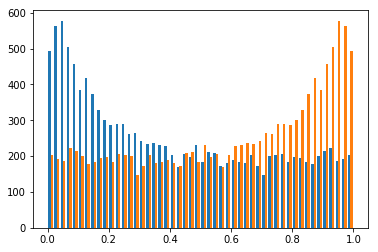

In [40]:
plt.figure()
plt.hist(pred, bins = 50)
plt.show()

In [41]:
get_class_weights(np.concatenate((Y_train, Y_val)))

{0: 14.8, 1: 1.0}